In [1]:
%pwd

'c:\\Users\\Fahmi Maulana\\Documents\\Projects\\weather-anomaly-detection\\exploratory-data-analysis\\notebooks'

In [2]:
%cd ../..

c:\Users\Fahmi Maulana\Documents\Projects\weather-anomaly-detection


c:\Users\Fahmi Maulana\.pyenv-win-venv\envs\weather-anomaly-detection\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils.stationary_utils import check_trend, check_seasonality

# Initial Data Inspection
## Loading Data

In [4]:
# Dictionary mapping weather codes to descriptions
weather_code_mapping = {
    0: "Clear Sky",
    1: "Mainly Clear",
    2: "Partly Cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing Rime Fog",
    51: "Drizzle: Light",
    53: "Drizzle: Moderate",
    55: "Drizzle: Dense",
    56: "Freezing Drizzle: Light",
    57: "Freezing Drizzle: Dense",
    61: "Rain: Slight",
    63: "Rain: Moderate",
    65: "Rain: Heavy",
    66: "Freezing Rain: Light",
    67: "Freezing Rain: Heavy",
    71: "Snow Fall: Slight",
    73: "Snow Fall: Moderate",
    75: "Snow Fall: Heavy",
    77: "Snow Grains",
    80: "Rain Showers: Slight",
    81: "Rain Showers: Moderate",
    82: "Rain Showers: Violent",
    85: "Snow Showers: Slight",
    86: "Snow Showers: Heavy",
    95: "Thunderstorm: Slight or Moderate",
    96: "Thunderstorm with Hail",
    99: "Thunderstorm with Hail"
}

In [5]:
pd.set_option("display.max_columns", None)
raw_df = pd.read_csv("./data/01_raw/jakarta_daily_weather_data_2010-2023.csv", 
                     date_parser=lambda x: pd.to_datetime(x).tz_convert('Asia/Bangkok'),
                     parse_dates=["date"],
                    )
raw_df["weather_description"] = raw_df["weather_code"].map(weather_code_mapping)
raw_df.rename(columns={"date":"datetime"}, inplace=True)
raw_df["date"] = raw_df["datetime"].dt.date
raw_df["year"] = raw_df["datetime"].dt.month
raw_df["month"] = raw_df.set_index("datetime").index.strftime('%B')
raw_df


C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_12052\3497725872.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  raw_df = pd.read_csv("./data/01_raw/jakarta_daily_weather_data_2010-2023.csv",


,datetime,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,weather_description,date,year,month
0,2010-01-01 00:00:00+07:00,55.0,29.346000,24.346000,26.493912,33.960170,28.426277,30.544830,0,0,44896.137,25858.787,4.000000,4.000000,0.0,14.0,15.978486,38.160000,245.528370,16.24,3.553079,Drizzle: Dense,2010-01-01,1,January
1,2010-01-02 00:00:00+07:00,63.0,30.696000,23.896000,26.858500,37.097730,28.470013,31.728783,0,0,44890.758,32148.900,6.500000,6.500000,0.0,4.0,14.707222,31.319998,237.893750,19.80,4.135429,Rain: Moderate,2010-01-02,1,January
2,2010-01-03 00:00:00+07:00,63.0,30.346000,24.246000,26.652250,36.627003,28.546375,31.245909,0,0,44884.926,38630.723,7.600000,7.600000,0.0,11.0,12.646200,26.640000,243.816120,17.32,3.662728,Rain: Moderate,2010-01-03,1,January
3,2010-01-04 00:00:00+07:00,51.0,30.196000,25.296000,27.308502,35.273200,29.467575,31.453005,0,0,44878.650,41568.150,0.900000,0.900000,0.0,5.0,19.319628,34.200000,239.246580,20.43,4.381917,Drizzle: Light,2010-01-04,1,January
4,2010-01-05 00:00:00+07:00,63.0,29.796000,24.746000,26.373077,35.096622,28.481304,30.532106,0,0,44871.930,24485.676,14.300001,14.300001,0.0,7.0,15.893093,32.039997,246.906390,15.86,3.420594,Rain: Moderate,2010-01-05,1,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5108,2023-12-27 00:00:00+07:00,61.0,30.765501,24.715500,27.171751,37.685635,29.997322,32.890606,0,0,44917.934,39061.520,5.800000,5.800000,0.0,12.0,13.450708,33.839996,341.221830,20.29,4.149257,Rain: Slight,2023-12-27,12,December
5109,2023-12-28 00:00:00+07:00,63.0,32.015500,24.315500,27.400917,38.291550,29.685040,33.214333,0,0,44915.016,42071.566,9.500000,9.500000,0.0,9.0,14.830076,34.920000,342.135070,23.21,4.722630,Rain: Moderate,2023-12-28,12,December
5110,2023-12-29 00:00:00+07:00,63.0,30.915500,24.965500,27.521751,38.060226,30.560104,33.526210,0,0,44911.582,35891.555,8.100000,8.100000,0.0,11.0,14.494192,36.000000,48.758728,19.28,3.979145,Rain: Moderate,2023-12-29,12,December
5111,2023-12-30 00:00:00+07:00,63.0,30.815500,24.065500,26.984251,38.101635,28.255577,32.431828,0,0,44907.640,39464.184,18.500000,18.500000,0.0,20.0,14.578890,32.399998,56.309900,20.25,4.109184,Rain: Moderate,2023-12-30,12,December


## Check Data Types

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype                       
---  ------                       --------------  -----                       
 0   datetime                     5113 non-null   datetime64[ns, Asia/Bangkok]
 1   weather_code                 5113 non-null   float64                     
 2   temperature_2m_max           5113 non-null   float64                     
 3   temperature_2m_min           5113 non-null   float64                     
 4   temperature_2m_mean          5113 non-null   float64                     
 5   apparent_temperature_max     5113 non-null   float64                     
 6   apparent_temperature_min     5113 non-null   float64                     
 7   apparent_temperature_mean    5113 non-null   float64                     
 8   sunrise                      5113 non-null   int64                       
 9   sunset             

## Check Missing Values

In [7]:
raw_df.isnull().sum()

datetime                       0
weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
sunrise                        0
sunset                         0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
weather_description            0
date                           0
year                           0
month                          0
dtype: int64

In [8]:
# Create a complete date range from 2010-01-01 to 2023-12-31
date_range = pd.date_range(start='2010-01-01', end='2023-12-31')

# Identify missing dates by comparing the date range with the dates in the dataset
missing_dates = date_range.difference(raw_df['date'])
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

## Descriptive Statistics

In [9]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
weather_code,5113.0,51.008410,18.619263,0.000000,51.000000,55.000000,63.000000,65.000000
temperature_2m_max,5113.0,29.956413,1.339548,24.396000,29.146000,29.996000,30.815500,35.065502
temperature_2m_min,5113.0,23.905324,0.706421,20.015501,23.465500,23.946000,24.365501,26.315500
temperature_2m_mean,5113.0,26.604937,0.802054,23.723082,26.075165,26.619667,27.155083,29.384254
apparent_temperature_max,5113.0,35.334246,1.769515,27.736720,34.262070,35.548650,36.595505,39.983460
apparent_temperature_min,5113.0,28.384033,1.175544,22.546871,27.639830,28.398770,29.218853,31.695213
apparent_temperature_mean,5113.0,31.361861,1.116031,26.712770,30.663467,31.465990,32.154026,34.196148
sunrise,5113.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sunset,5113.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
daylight_duration,5113.0,43599.501803,888.710826,42353.523000,42730.420000,43564.445000,44464.715000,44924.490000


# Initial Visualizations
## Time Series Plot

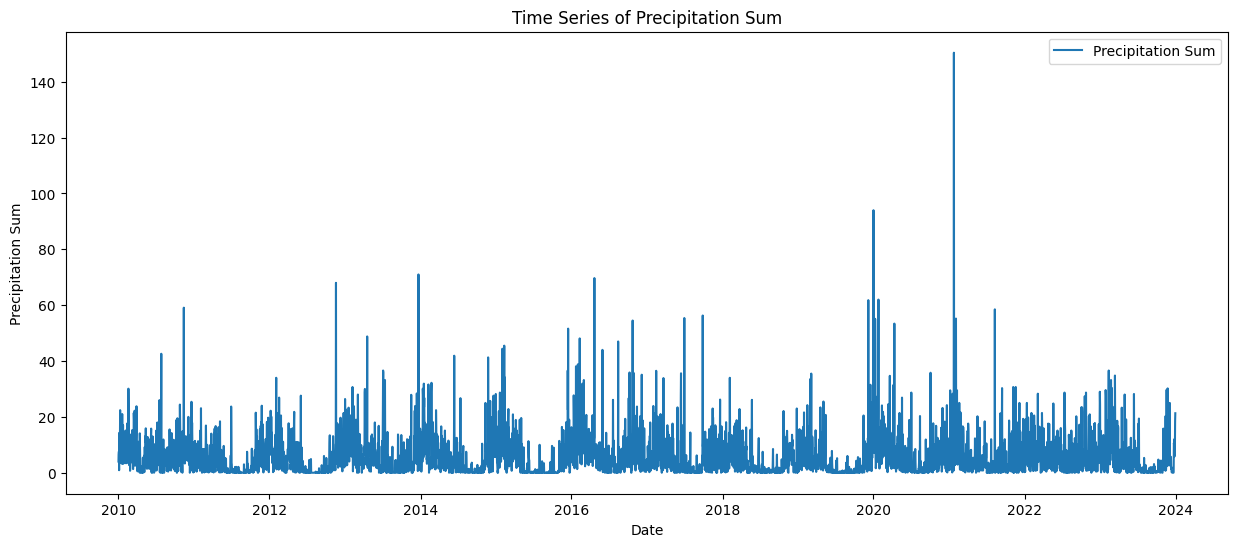

In [10]:
# Time series plot of precipitation_sum
plt.figure(figsize=(15, 6))
plt.plot(raw_df['date'], raw_df['precipitation_sum'], label='Precipitation Sum')
plt.xlabel('Date')
plt.ylabel('Precipitation Sum')
plt.title('Time Series of Precipitation Sum')
plt.legend()
plt.show()

In [11]:
fig = px.line(raw_df, x='date', y='precipitation_sum', title='Precipitation Sum Time Series')
fig.update_xaxes(rangeslider_visible=True)

# Set the height and width of the chart
fig.update_layout(height=600, width=1000)

# Center-align the title
fig.update_layout(title_x=0.5)

fig.show()

## Distribution Plot

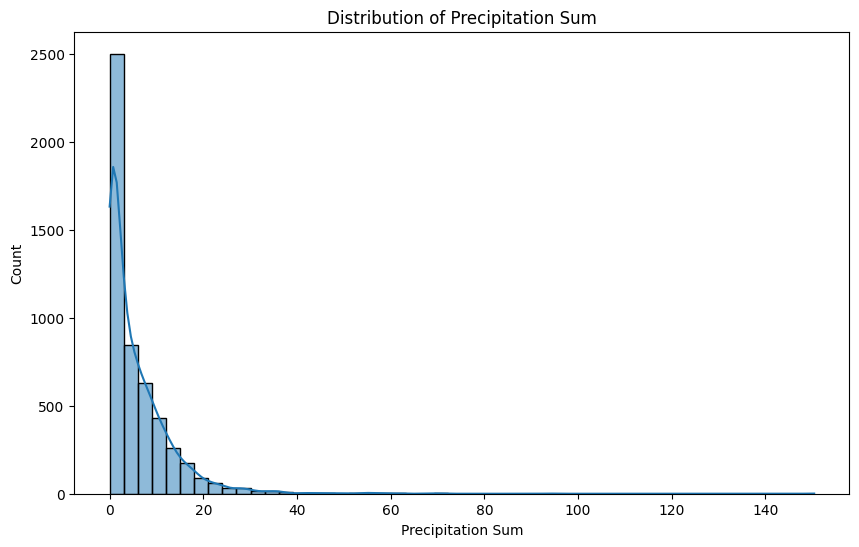

In [12]:
# Distribution plot of precipitation_sum
plt.figure(figsize=(10, 6))
sns.histplot(raw_df['precipitation_sum'], bins=50, kde=True)
plt.xlabel('Precipitation Sum')
plt.title('Distribution of Precipitation Sum')
plt.show()


## Box Plot

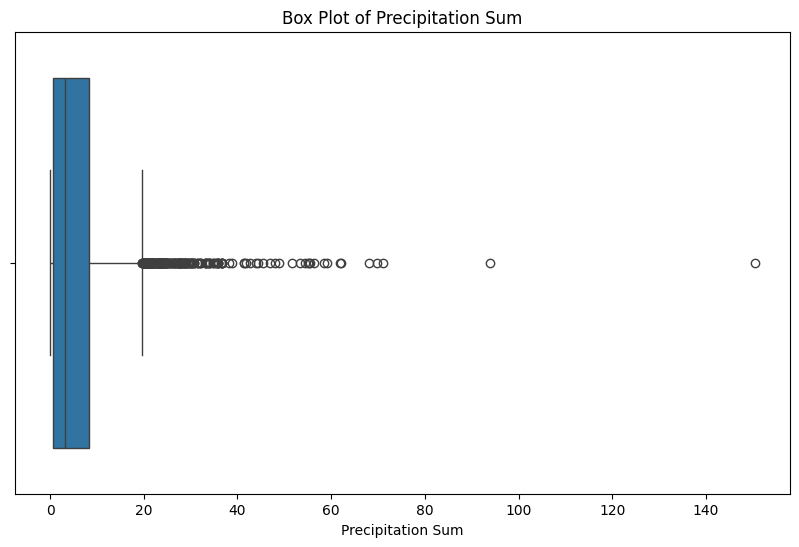

In [13]:
# Box plot to identify outliers in precipitation_sum
plt.figure(figsize=(10, 6))
sns.boxplot(x=raw_df['precipitation_sum'])
plt.xlabel('Precipitation Sum')
plt.title('Box Plot of Precipitation Sum')
plt.show()

# Trend and Seasonality Analysis
## Decompose Time Series

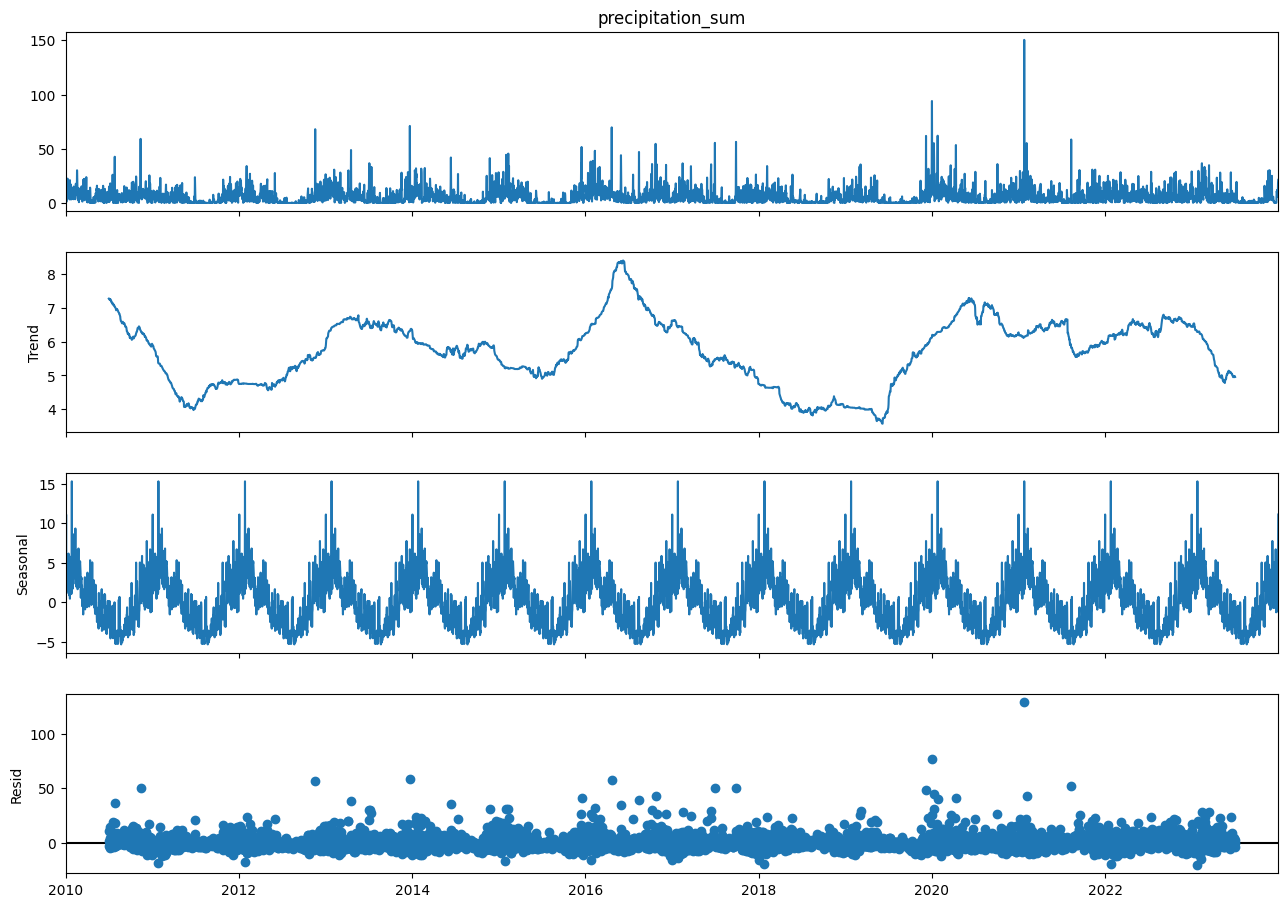

In [14]:
# Seasonal decomposition of time series data
decomposition = seasonal_decompose(raw_df.set_index('date')['precipitation_sum'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

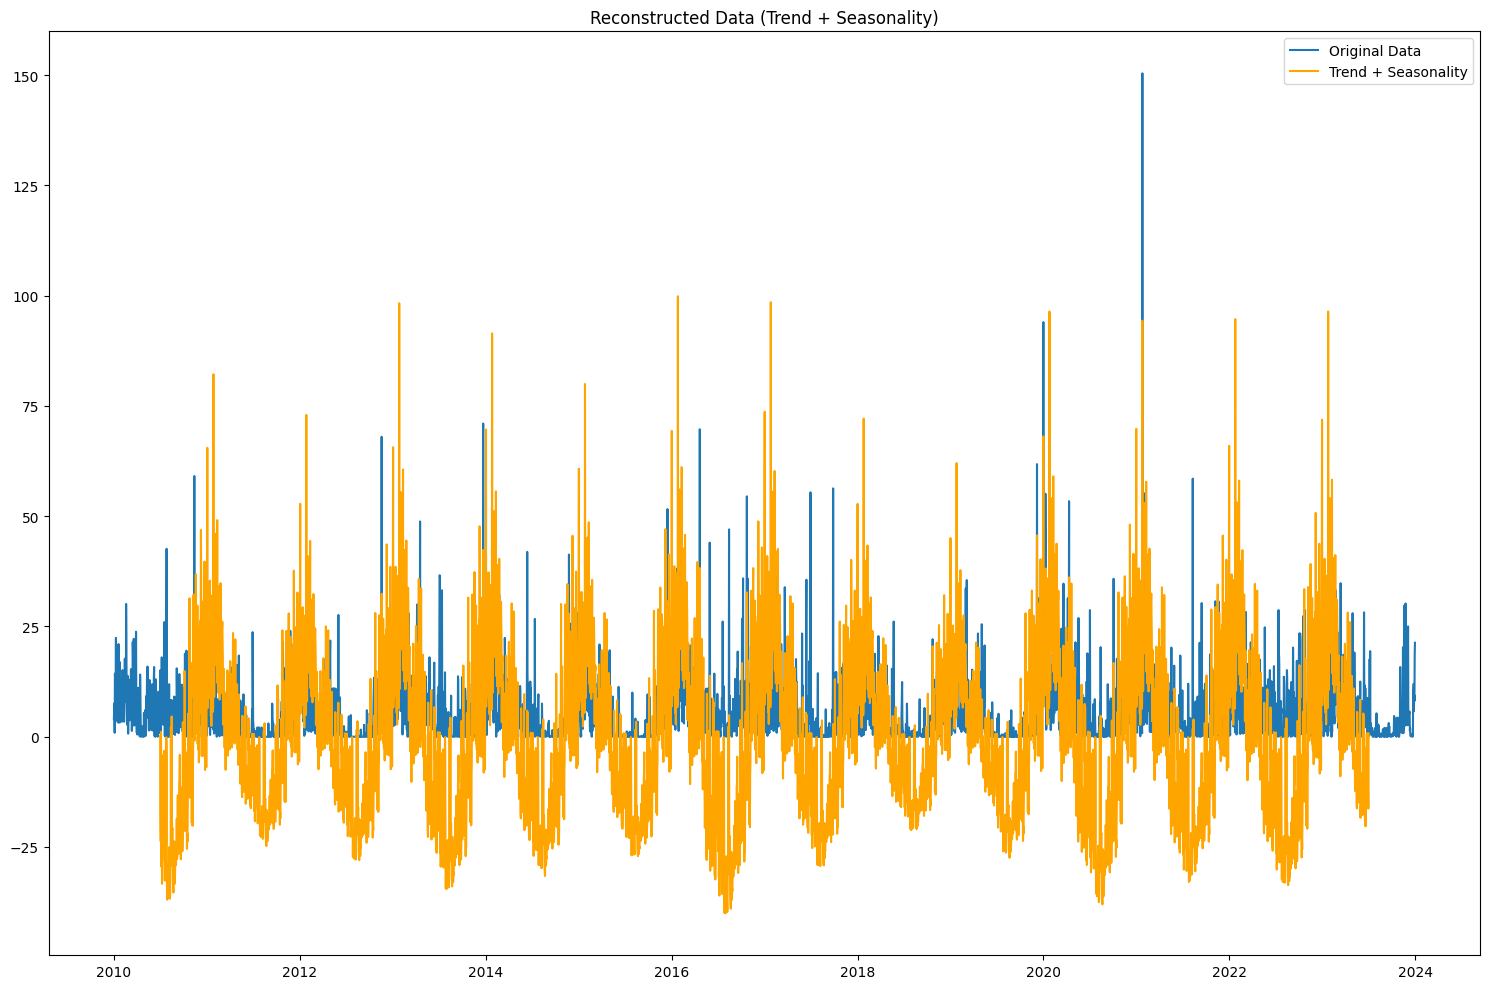

In [15]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

reconstructed = trend * seasonal

# Plot perbandingan antara data asli dengan hasil dekomposisi
plt.figure(figsize=(15, 10))

plt.plot(raw_df.set_index('date')['precipitation_sum'], label='Original Data')
plt.plot(reconstructed, label='Trend + Seasonality', color='orange')
plt.title('Original Data')
plt.title('Reconstructed Data (Trend + Seasonality)')
plt.legend()

plt.tight_layout()
plt.show()

## Check Trend and Seasonality

In [16]:
kendall_tau_res = check_trend(raw_df.set_index('date')['precipitation_sum'], confidence=0.05)
mann_kendall_res = check_trend(raw_df.set_index('date')['precipitation_sum'], confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(raw_df.set_index('date')['precipitation_sum'], confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: False | Direction: decreasing | Deterministic: False


In [17]:
seasonality_res = check_seasonality(raw_df.set_index('date')['precipitation_sum'], max_lag=366, seasonal_period=365, confidence=0.05)
print(f"Seasonality Test for 365th lag using monthly data: {seasonality_res.seasonal}")

Seasonality Test for 365th lag using monthly data: True


## Monthly Data

In [18]:
# Resample the data to monthly sums to see trends
raw_df_monthly = raw_df.drop(["date", "year", "month"], axis=1).set_index("datetime").resample('ME').sum()
raw_df_monthly["month"] = raw_df_monthly.index.strftime('%b')
raw_df_monthly["year"] = raw_df_monthly.index.year
raw_df_monthly

,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,weather_description,month,year
datetime,,,,,,,,,,,,,,,,,,,,,,,
2010-01-31 00:00:00+07:00,1861.0,887.176000,734.576000,798.907218,1049.533746,864.673160,938.214389,0,0,1387296.302,9.474297e+05,297.200002,297.200002,0.0,444.0,449.595275,1006.199987,8325.424050,521.77,105.641920,Drizzle: DenseRain: ModerateRain: ModerateDriz...,Jan,2010
2010-02-28 00:00:00+07:00,1696.0,819.888000,673.688000,737.800459,999.898716,812.434231,889.660480,0,0,1240034.325,9.305019e+05,275.099997,275.099997,0.0,385.0,308.963031,701.999978,6763.760038,509.44,103.032984,Drizzle: ModerateRain: SlightRain: SlightRain:...,Feb,2010
2010-03-31 00:00:00+07:00,1871.0,911.026000,748.676000,815.617642,1110.075626,903.232708,984.327952,0,0,1354566.908,9.221890e+05,321.100000,321.100000,0.0,414.0,326.916572,745.919972,6975.228789,530.35,107.602009,Rain: ModerateRain: ModerateDrizzle: ModerateR...,Mar,2010
2010-04-30 00:00:00+07:00,1506.0,919.130000,733.230000,815.921641,1104.144661,875.777251,972.280535,0,0,1292861.988,1.114680e+06,95.100001,95.100001,0.0,154.0,344.298092,774.359991,7074.856980,590.76,123.266735,Drizzle: ModerateRain: ModerateDrizzle: Modera...,Apr,2010
2010-05-31 00:00:00+07:00,1845.0,934.876000,755.776000,832.944705,1126.592181,917.580927,1006.391387,0,0,1320962.126,1.068944e+06,195.300006,195.300006,0.0,243.0,324.401172,767.519993,4986.354841,517.31,106.177666,Drizzle: LightDrizzle: LightDrizzle: LightRain...,May,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 00:00:00+07:00,1130.0,980.780513,727.180507,846.199295,1116.327246,849.809985,967.168315,0,0,1329647.805,1.228950e+06,19.300000,19.300000,0.0,62.0,586.469960,1288.439971,2725.380376,640.56,141.412808,Partly CloudyRain: ModerateDrizzle: ModeratePa...,Aug,2023
2023-09-30 00:00:00+07:00,972.0,967.915015,708.865018,828.604636,1095.278927,814.639591,937.277580,0,0,1303584.579,1.203721e+06,18.700000,18.700000,0.0,64.0,602.970398,1327.319952,5179.506315,683.99,154.481376,Mainly ClearRain: SlightDrizzle: LightDrizzle:...,Sep,2023
2023-10-31 00:00:00+07:00,1465.0,1021.630511,764.530510,881.120104,1164.869367,903.679322,1018.592430,0,0,1365948.939,1.234793e+06,39.800000,39.800000,0.0,100.0,573.367949,1337.759965,4934.678696,714.37,160.630489,Drizzle: LightDrizzle: LightDrizzle: LightDriz...,Oct,2023


<Axes: xlabel='month', ylabel='precipitation_sum'>

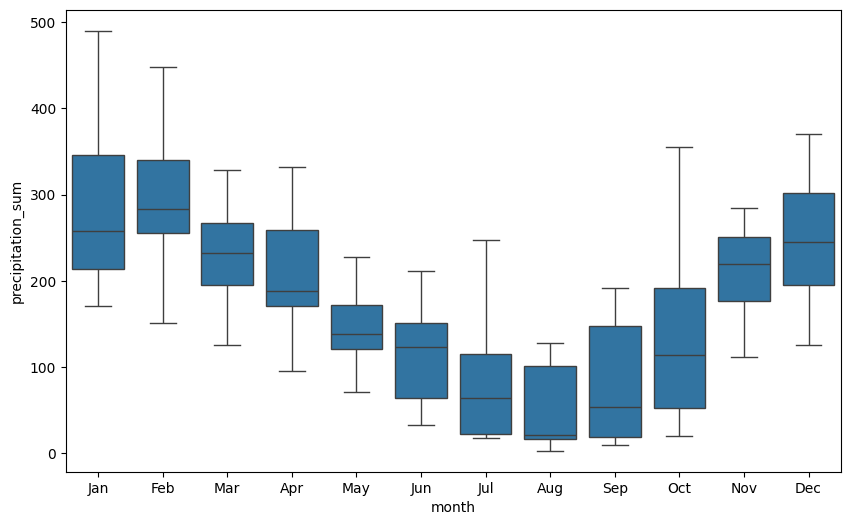

In [19]:
raw_df_monthly_seasonal = raw_df_monthly[["month", "year", "precipitation_sum"]].reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.boxplot(data=raw_df_monthly_seasonal, x="month", y="precipitation_sum")

<Axes: xlabel='year', ylabel='precipitation_sum'>

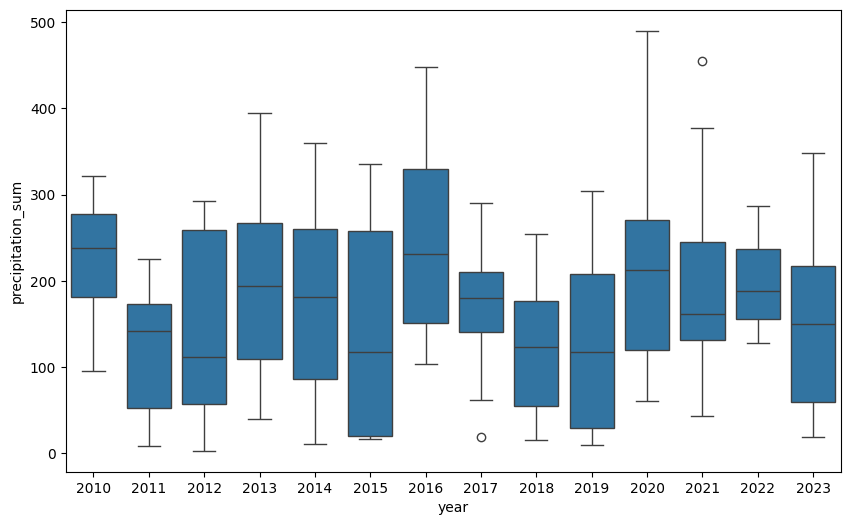

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(data=raw_df_monthly_seasonal, x="year", y="precipitation_sum")

<Axes: xlabel='year', ylabel='precipitation_sum'>

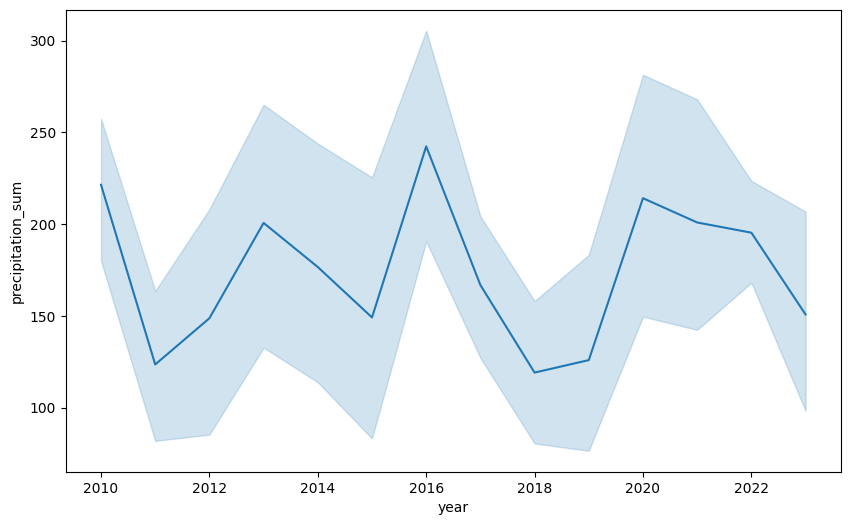

In [21]:
plt.figure(figsize=(10,6))
sns.lineplot(data=raw_df_monthly_seasonal, x="year", y="precipitation_sum")

In [22]:
# Create the plot
fig = px.line(raw_df_monthly_seasonal, x='month', y='precipitation_sum', color='year', symbol='year', title='Monthly Precipitation Sum by Year')

# Update layout for figure size
fig.update_layout(width=1000, height=600)

# Add annotations for each year's end of line
for year in raw_df_monthly_seasonal['year'].unique():
    # Get the last data point for each year
    df_year = raw_df_monthly_seasonal[raw_df_monthly_seasonal['year'] == year]
    last_month = df_year['month'].iloc[-1]
    last_precipitation_sum = df_year['precipitation_sum'].iloc[-1]
    
    # Add annotation
    fig.add_annotation(
        x=last_month,
        y=last_precipitation_sum,
        text=str(year),
        showarrow=False,
        xanchor='left'
    )

# Show plot
fig.show()

## Check Trend and Seasonality on Monthly Data

In [23]:
kendall_tau_res = check_trend(raw_df_monthly_seasonal['precipitation_sum'], confidence=0.05)
mann_kendall_res = check_trend(raw_df_monthly_seasonal['precipitation_sum'], confidence=0.05, mann_kendall=True)
mann_kendall_seas_res = check_trend(raw_df_monthly_seasonal['precipitation_sum'], confidence=0.05, mann_kendall=True, seasonal_period=None)
print(f"Kendalls Tau: Trend: {kendall_tau_res.trend} | Direction: {kendall_tau_res.direction} | Deterministic: {kendall_tau_res.deterministic}")
print(f"Mann-Kendalls: Trend: {mann_kendall_res.trend} | Direction: {mann_kendall_res.direction} | Deterministic: {mann_kendall_res.deterministic}")
print(f"Mann-Kendalls Seasonal: Trend: {mann_kendall_seas_res.trend} | Direction: {mann_kendall_seas_res.direction} | Deterministic: {mann_kendall_seas_res.deterministic}")

Kendalls Tau: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls: Trend: False | Direction: decreasing | Deterministic: False
Mann-Kendalls Seasonal: Trend: False | Direction: decreasing | Deterministic: False


In [24]:
seasonality_res = check_seasonality(raw_df_monthly_seasonal['precipitation_sum'], max_lag=14, seasonal_period=12, confidence=0.05)
print(f"Seasonality Test for 12th lag using monthly data: {seasonality_res.seasonal}")

Seasonality Test for 12th lag using monthly data: True


# Stationary Test (ADF and KPSS Test)

In [25]:
def unitroot_test_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [26]:
adf_price_output = adfuller(raw_df.set_index("date")["precipitation_sum"])
kpss_price_output = kpss(raw_df.set_index("date")["precipitation_sum"])

pd.concat([
    unitroot_test_results(adf_price_output, 'adf'),
    unitroot_test_results(kpss_price_output, 'kpss')
], axis=1)

C:\Users\Fahmi Maulana\AppData\Local\Temp\ipykernel_12052\668242819.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




,adf,kpss
Test Statistic,-6.879348,0.056547
p-value,0.0,0.1
Numbers of lags,24,34
decision,Stationary,Stationary
Critical Value (1%),-3.431636,0.739
Critical Value (5%),-2.862108,0.463
Critical Value (10%),-2.567072,0.347
Critical Value (2.5%),NaN,0.574


# Autocorrelation and PACF plots

<Figure size 1000x600 with 0 Axes>

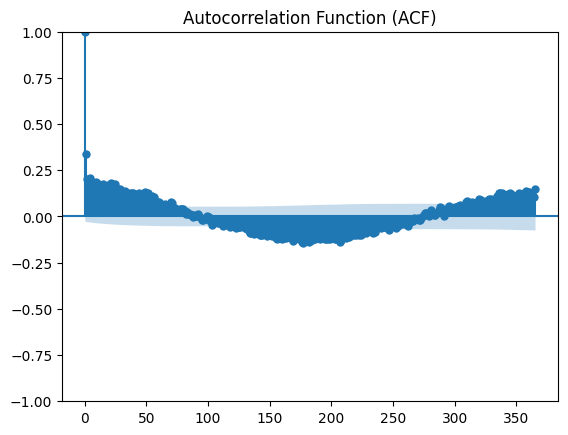

<Figure size 1000x600 with 0 Axes>

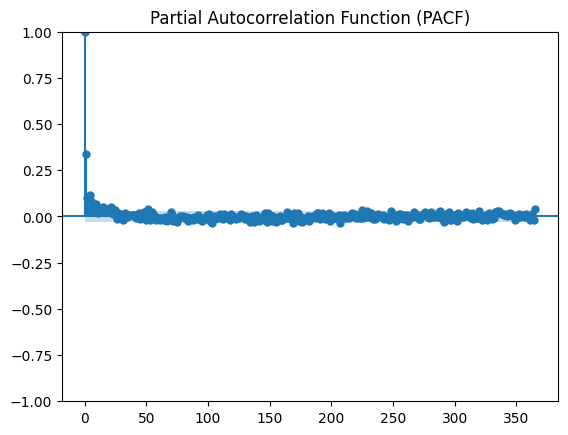

In [27]:
# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(raw_df.set_index("date")["precipitation_sum"], lags=365)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(raw_df.set_index("date")["precipitation_sum"], lags=365)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

# Anomaly Detection
## Based on Residual of Decomposition Time Series

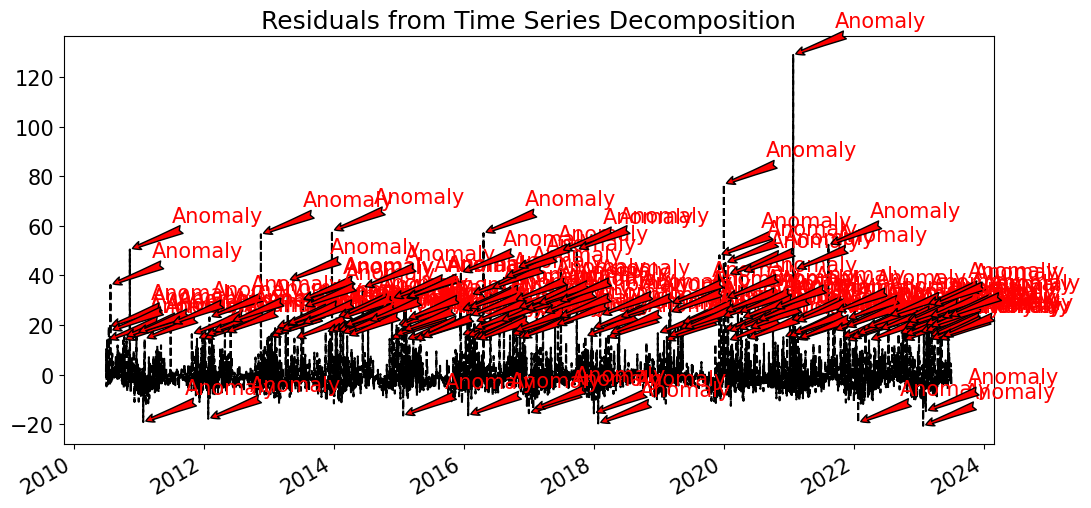

In [28]:
# Plot the residuals
plt.rc('figure', figsize=(12, 6))
plt.rc('font', size=15)
fig, ax = plt.subplots()
x = residual.index
y = residual.values
ax.plot(x, y, color='black', linestyle='--')
ax.set_title('Residuals from Time Series Decomposition')
fig.autofmt_xdate()

# Detect anomalies (e.g., residuals exceeding 2 standard deviations)
threshold = 2
residual_mean = np.mean(residual)
residual_std = np.std(residual)
anomalies = residual[np.abs(residual - residual_mean) > threshold * residual_std]

# Annotate anomalies
for idx in anomalies.index:
    ax.annotate('Anomaly', (mdates.date2num(idx), residual.loc[idx]), xytext=(30, 20),
                textcoords='offset points', color='red',
                arrowprops=dict(facecolor='red', arrowstyle='fancy'))

plt.show()

In [29]:
import plotly.graph_objects as go

# Define residual, mean, and std
residual_mean = np.mean(residual)
residual_std = np.std(residual)
threshold = 2

# Detect anomalies
anomalies = residual[np.abs(residual - residual_mean) > threshold * residual_std]

# Create the residual plot
fig = go.Figure()

# Plot the actual values
fig.add_trace(go.Scatter(
    x=raw_df.date, 
    y=raw_df.precipitation_sum,
    mode='lines',
    name='Actual Values'
))


# Plot the residuals
fig.add_trace(go.Scatter(
    x=residual.index, 
    y=residual.values,
    mode='lines',
    line=dict(color='aqua', dash='solid'),
    name='Residuals'
))

# Annotate anomalies
for idx in anomalies.index:
    fig.add_annotation(
        x=idx,
        y=residual.loc[idx],
        text="Anomaly",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='red',
        ax=30,  # x offset
        ay=20,  # y offset
        font=dict(color='red')
    )

# Update layout
fig.update_layout(
    title='Anomaly Detection in Residuals Using Mean and Standard Deviation',
    xaxis_title='Date',
    yaxis_title='Precipitation',
    font=dict(size=15),
    autosize=True,
    width=1200,
    height=600
)

# Show the figure
fig.show()

### Normality Check

In [32]:
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [33]:
normal_args = (np.mean(residual),np.std(residual))

print(is_normal(shapiro(residual)))
print(is_normal(normaltest(residual)))
print(is_normal(normal_ad(residual)))
print(is_normal(kstest_normal(residual)))

Not Normal
Not Normal
Not Normal
Not Normal


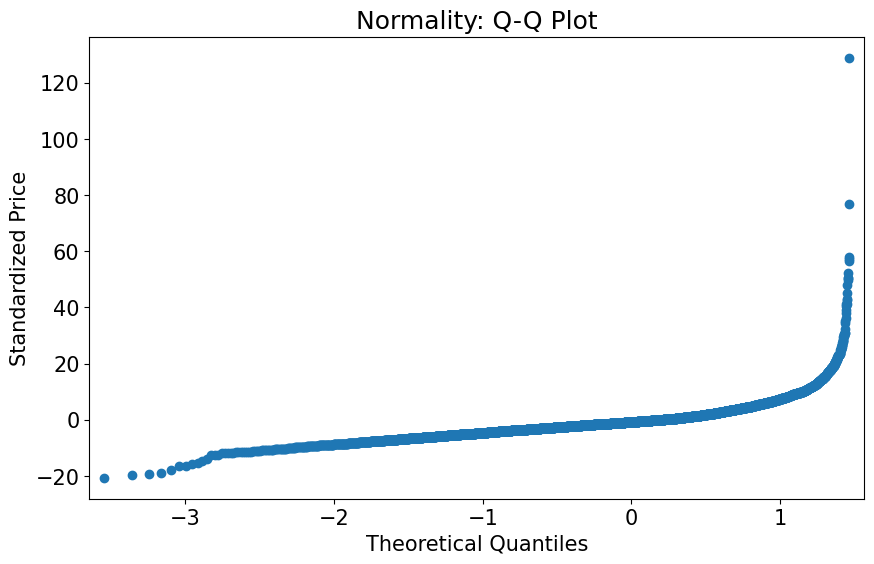

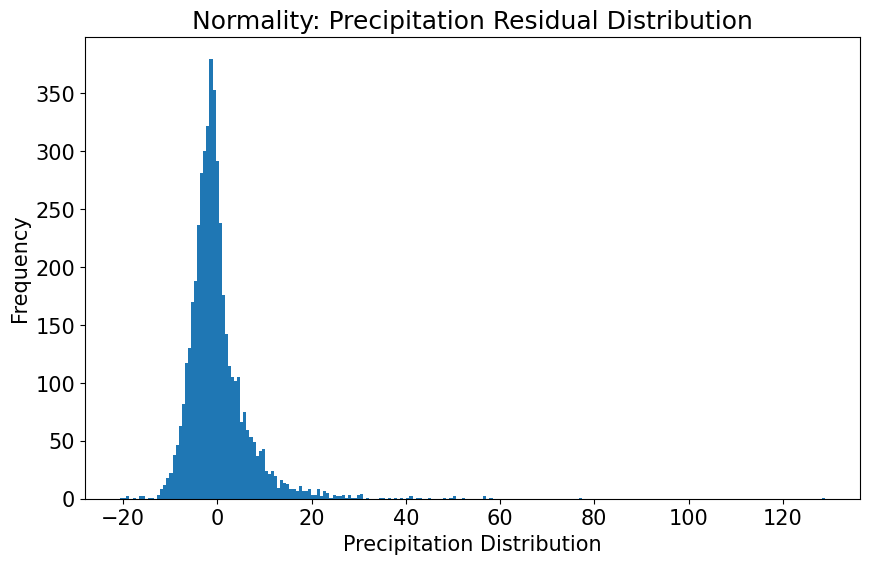

In [38]:
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = [10, 6]

sm.qqplot(residual)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Price')
plt.title('Normality: Q-Q Plot')
plt.show()

plt.hist(residual, bins='auto')
plt.xlabel('Precipitation Distribution')
plt.ylabel('Frequency')
plt.title('Normality: Precipitation Residual Distribution')
plt.show()

## Median and Median Absolute Deviation (MAD)

In [55]:
# Define residual, median, and MAD
residual_median = np.median(residual.dropna())
residual_mad = np.median(np.abs(residual.dropna() - residual_median))
threshold = 3  # Define the threshold for anomaly detection

# Detect anomalies
anomalies = residual[np.abs(residual - residual_median) > threshold * residual_mad]

# Create the residual plot
fig = go.Figure()

# Plot the actual values
fig.add_trace(go.Scatter(
    x=raw_df.date, 
    y=raw_df.precipitation_sum,
    mode='lines',
    name='Actual Values'
))

# Plot the residuals
fig.add_trace(go.Scatter(
    x=residual.index, 
    y=residual.values,
    mode='lines',
    line=dict(color='aqua', dash='solid'),
    name='Residuals'
))

# Annotate anomalies
for idx in anomalies.index:
    fig.add_annotation(
        x=idx,
        y=residual.loc[idx],
        text="Anomaly",
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor='red',
        ax=30,  # x offset
        ay=20,  # y offset
        font=dict(color='red')
    )

# Update layout
fig.update_layout(
    title='Anomaly Detection in Residuals Using Mean and Standard Deviation',
    xaxis_title='Date',
    yaxis_title='Precipitation',
    font=dict(size=15),
    autosize=True,
    width=1200,
    height=600
)

# Show the figure
fig.show()
